In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import voigt_profile

In [55]:
def voigt(x, a, s, g):
    return a * voigt_profile(x, s, g)


def bivoigt(x, a1, s1, g1, a2, s2, g2):
    return a1 * voigt_profile(x, s1, g1) + a2 * voigt_profile(x - 228.2, s2, g2)


def bivoigt_equal(x, a1, a2, s, g):
    return a1 * voigt_profile(x, s, g) + a2 * voigt_profile(x - 228.2, s, g)


def bivoigt_equal2(x, a1, a2, s):
    return a1 * voigt_profile(x, s, 11.0) + a2 * voigt_profile(x - 228.2, s, 11.0)

def preprocess(x, y, left=0.2, right=0.2):
    plt.figure(figsize=(12, 4))
    plt.plot(x, y, color="blue")

    cut1 = round(len(x) * left)
    cut2 = round(len(x) * right)
    temp_x, temp_y = x[cut1:-cut2], y[cut1:-cut2]

    plt.plot(temp_x, temp_y, color="red")
    plt.tight_layout()
    return temp_x, temp_y


def process(x, y, left=0.2, right=0.2, mid=0.5):
    plt.figure(figsize=(14, 4))
    
    plt.subplot(221)
    plt.plot(x, y, color="blue")

    cut1 = round(len(x) * left)
    cut2 = round(len(x) * right)
    k1, b1 = np.polyfit(x[:cut1], y[:cut1], deg=1)
    k2, b2 = np.polyfit(x[-cut2:], y[-cut2:], deg=1)

    plt.subplot(222)
    plt.plot(x, y, color="blue")
    plt.plot(x, k1 * x + b1, color="green")
    plt.plot(x, k2 * x + b2, color="red")

    temp_x, temp_y = x[:], y[:]

    plt.subplot(223)
    intercept = len(x[x < (b2 - b1) / (k1 - k2)])
    temp_y[:intercept] -= (k1 * x[:intercept] + b1)
    temp_y[intercept:] -= (k2 * x[intercept:] + b2)
    plt.plot(temp_x[:round(len(temp_x) * mid)], temp_y[:round(len(temp_x) * mid)], color="red")
    plt.plot(temp_x[round(len(temp_x) * mid):], temp_y[round(len(temp_x) * mid):], color="blue")

    

    plt.subplot(224)
    
    
    idx1, idx2 = np.argmax(temp_y[:round(len(temp_x) * mid)]), np.argmax(temp_y[round(len(temp_x) * mid):]) + round(len(temp_x) * mid)
    m1, m2 = temp_x[idx1], temp_x[idx2]

    temp_x = (temp_x - m1) * 228.2 / (m2 - m1)
    temp_y *= (5.7 / 20 / (0.95 * 0.013)

    plt.scatter(temp_x, temp_y, color="red", s=10, alpha=0.2)

    kernel_size = 500
    kernel = np.ones(kernel_size) / kernel_size
    temp_y = np.convolve(temp_y, kernel, mode='same')

    plt.figure(figsize=(8, 6))
    plt.plot(temp_x, temp_y, color="blue")
    plt.xlabel("MHz")
    plt.ylabel("nW")

    plt.tight_layout()

    return temp_x, temp_y, idx1, idx2


def fit(x, y, idx1, idx2):
    p1, p2 = curve_fit(voigt, x[:idx1], y[:idx1])[0], curve_fit(voigt, x[idx2:] - 228.2, y[idx2:])[0]
    a1, s1, g1, a2, s2, g2 = *p1, *p2
    s = (s1 + s2) / 2
    g = (g1 + g2) / 2

    params = curve_fit(bivoigt_equal, x, y, [a1, a2, s, g])[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, voigt(x, *p1) + voigt(x - 228.2, *p2), color="blue", label="sum")
    plt.xlabel("MHz")
    plt.ylabel("nW")
    plt.legend()

    plt.subplot(122)
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, bivoigt_equal(x, *params), color="red", label="equal")
    plt.legend()
    plt.xlabel("MHz")
    plt.ylabel("nW")

    plt.tight_layout()

    return params, [a1, a2, s1, s2, g1, g2]

def fit2(x, y, idx1, idx2):
    p1, p2 = curve_fit(voigt, x[:idx1], y[:idx1])[0], curve_fit(voigt, x[idx2:] - 228.2, y[idx2:])[0]
    a1, s1, g1, a2, s2, g2 = *p1, *p2
    s = (s1 + s2) / 2
    g = (g1 + g2) / 2

    params = curve_fit(bivoigt_equal, x, y, [a1, a2, s])[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, voigt(x, *p1) + voigt(x - 228.2, *p2), color="blue", label="sum")
    plt.xlabel("MHz")
    plt.ylabel("nW")
    plt.legend()

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, bivoigt_equal(x, *params), color="red")
    plt.legend()
    plt.xlabel("МГц", fontsize=14)
    plt.ylabel("нВт", fontsize=14)
    plt.title("Сумма профилей Фойгта после обработки", fontsize=14)

    plt.tight_layout()

    return params, [a1, a2, s1, s2, g1, g2]


SyntaxError: '(' was never closed (3604842309.py, line 63)

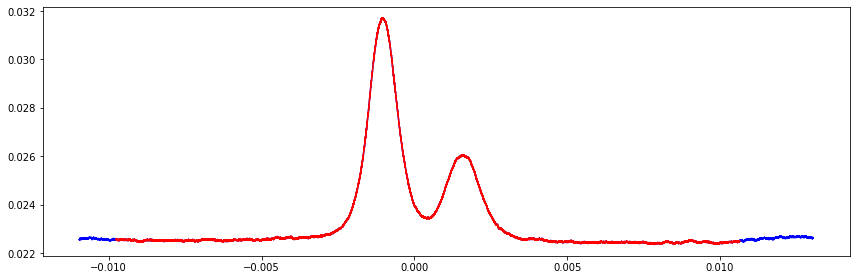

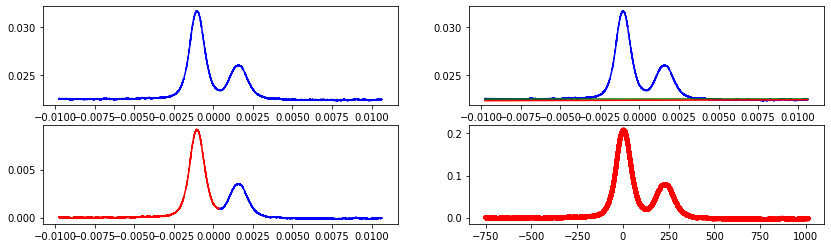

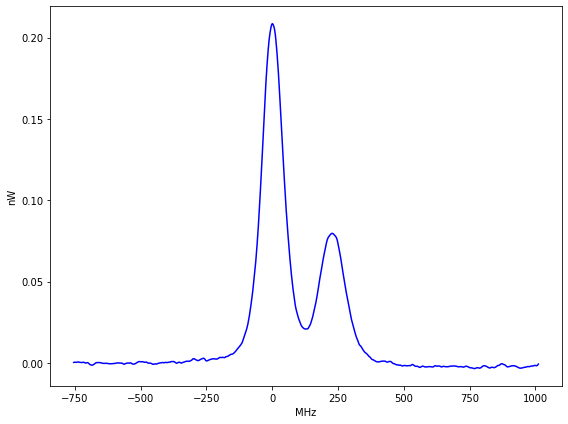

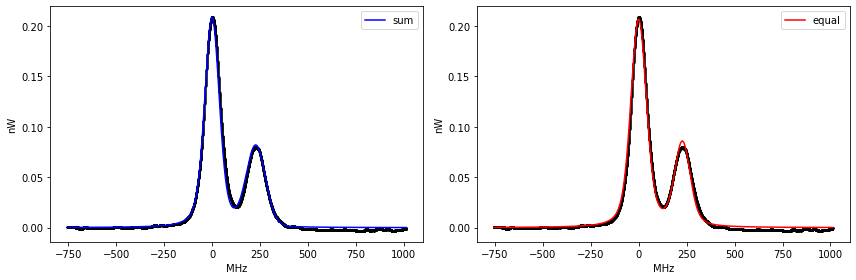

In [60]:
data = pd.read_csv("data/new_data/OPEN.CSV")

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.05, 0.1)

x, y, idx1, idx2 = process(x, y, 0.2, 0.2, 0.5)

params78 = fit(x, y, idx1, idx2)[0]

1.092106e+11


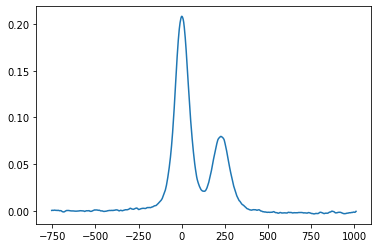

In [63]:
plt.plot(x, y)

P = np.trapz(y, x) 

print("{:e}".format(P * 10**(34-12-9)/(6.62*447)))

24.19617588883376

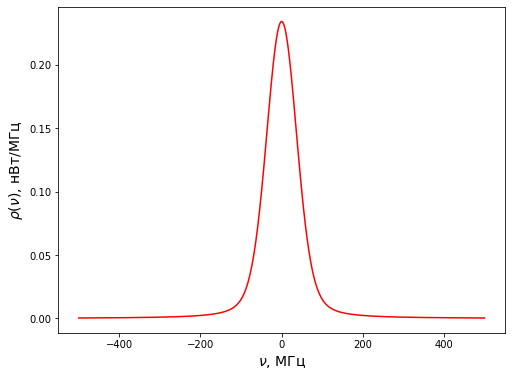

In [58]:
x = np.linspace(-500, 500, 1000000)
y = voigt(x, a1, s, 11.0)

plt.figure(figsize=(8,6))
plt.plot(x, y, color="red")
plt.xlabel("$\\nu$, МГц", fontsize=14)
plt.ylabel("$\\rho(\\nu)$, нВт/МГц", fontsize=14)

P = np.trapz(y, x)
P
# N_ph = P / (6.62 * 10**(-34+12) * 447)
# N_ph

In [48]:
print("{:e}".format(3 * P * 10**(34-12-9)/(6.62*447)))

2.453028e+11


Text(0, 0.5, 'Напряжение, В')

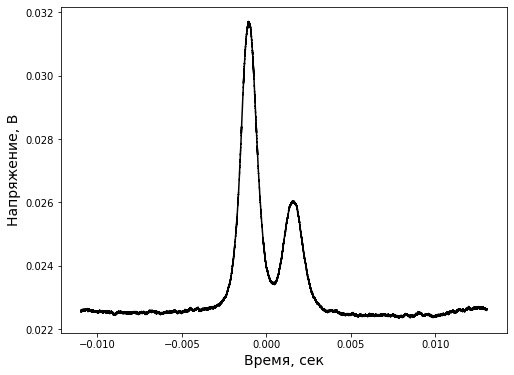

In [23]:
data = pd.read_csv("data/new_data/OPEN.CSV")

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])


plt.figure(figsize=(8, 6))
plt.plot(x, y, color="black")
plt.xlabel("Время, сек", fontsize=14)
plt.ylabel("Напряжение, В", fontsize=14)

In [50]:
0.0013 * 0.95

0.001235

In [53]:
(2*1.38*10**(-23) * (400+273) /(6.01 * 1.66 * 10**(-27)))**(1/2)

1364.4913696586807

In [54]:
4.5/1364

0.0032991202346041057

Text(0, 0.5, 'Напряжение, В')

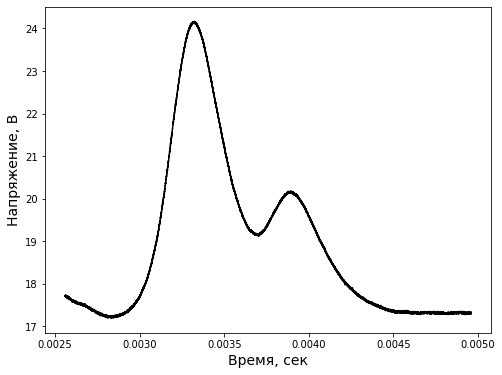

In [76]:
data = pd.read_csv("data/old_data/400.CSV")

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 1])
cut1 = round(len(x) * 0.45)
cut2 = round(len(x) * 0.45)

plt.figure(figsize=(8, 6))
plt.plot(x[cut1:-cut2], y[cut1:-cut2], color="black")
plt.xlabel("Время, сек", fontsize=14)
plt.ylabel("Напряжение, В", fontsize=14)


plt.savefig()